In [1]:
import numpy as np 
import cv2
import glob
import os
import matplotlib.pyplot as plt
import pickle
import random
import string
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC

In [2]:
pick_in=open('projdata1.pickle','rb')
data=pickle.load(pick_in)
pick_in.close()

In [3]:
random.shuffle(data)
features=[]
labels=[]

for feature, label in data:
    features.append(feature)
    labels.append(label)
    
print(type(features))
print(type(labels))
print(len(features))
m = np.asarray(features)
print(m.shape)
m = m.astype(np.float64)
m -= m.mean()


import torch
ften=torch.tensor(features)
print(ften.shape)

<class 'list'>
<class 'list'>
3600
(3600, 2500)
torch.Size([3600, 2500])


In [4]:
from tensorly.decomposition import robust_pca
low_rank_part, sparse_part = robust_pca(m, reg_E=0.04, learning_rate=1.2, n_iter_max=20)

In [6]:
print(type(low_rank_part))
print(low_rank_part.shape)

<class 'numpy.ndarray'>
(3600, 2500)


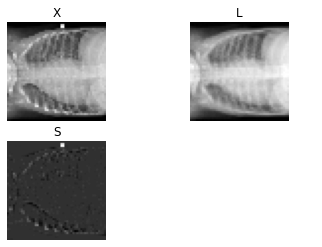

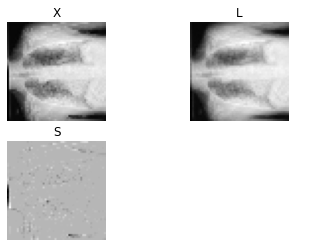

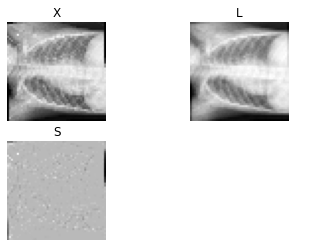

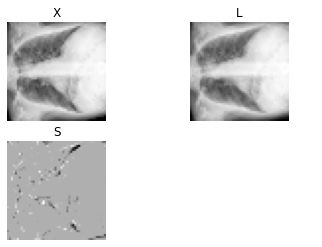

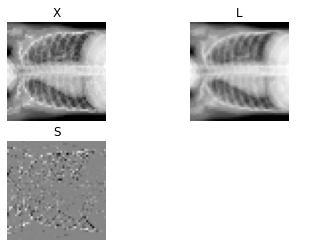

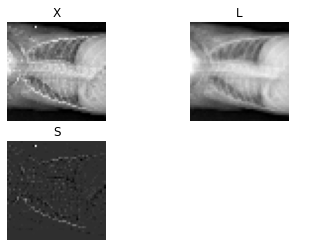

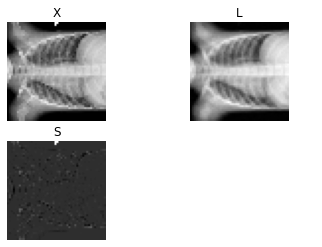

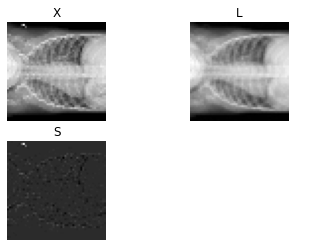

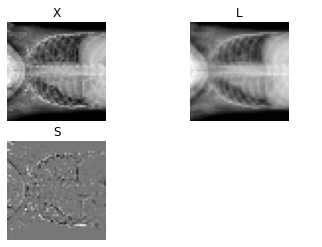

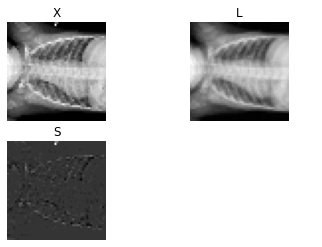

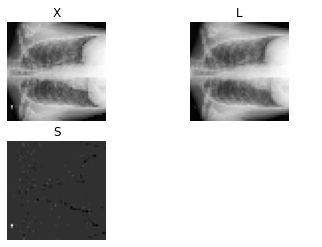

In [7]:
inds = (3,4,14,15,17,18,19,20,21,32,43)

for k in inds:
    fig,axs = plt.subplots(2,2)
    axs = axs.reshape(-1)
    axs[0].imshow(np.reshape(m[k-1,:],(50,50)).T,cmap='gray')
    axs[0].set_title('X')
    axs[1].imshow(np.reshape(low_rank_part[k-1,:],(50,50)).T,cmap='gray')
    axs[1].set_title('L')
    axs[2].imshow(np.reshape(sparse_part[k-1,:],(50,50)).T,cmap='gray')
    axs[2].set_title('S')
    for ax in axs:
        ax.axis('off')

In [8]:
list1 = low_rank_part.tolist()

In [9]:
xtrain, xtest, ytrain, ytest=train_test_split(list1,labels, test_size=0.25)

In [11]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=10, whiten=True)
pca.fit(xtrain)
xtrain_pca = pca.transform(xtrain)
xtest_pca = pca.transform(xtest)
print(xtrain_pca.shape)
print(xtest_pca.shape)

(2700, 10)
(900, 10)


In [12]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [13]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000], #Regularization parameter
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10] #number of trees in the forest
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),#penalty='l1',solver='saga',multi_class='auto'
        'params': {
            'logisticregression__C': [1,5,10] #regularization 
        }
    }
}

In [14]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(xtrain_pca, ytrain)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.885185,"{'svc__C': 1, 'svc__kernel': 'rbf'}"
1,random_forest,0.858889,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.856667,{'logisticregression__C': 10}


In [15]:
best_estimators['svm'].score(xtest_pca,ytest)

0.8855555555555555

In [16]:
best_estimators['random_forest'].score(xtest_pca,ytest)

0.8711111111111111

In [17]:
best_estimators['logistic_regression'].score(xtest_pca,ytest)

0.8322222222222222

In [19]:
from sklearn.metrics import confusion_matrix
best_clf = best_estimators['svm']
cm = confusion_matrix(ytest, best_clf.predict(xtest_pca))
cm

array([[275,   5,  13],
       [  7, 261,  33],
       [  7,  38, 261]], dtype=int64)